In [43]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random

df=pd.read_csv('/content/drive/MyDrive/ml mini proj mtech/deceptive-opinion.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   hotel      1600 non-null   object
 2   polarity   1600 non-null   object
 3   source     1600 non-null   object
 4   text       1600 non-null   object
dtypes: object(5)
memory usage: 62.6+ KB


In [ ]:
# Statistical measures of the data
df.describe()

,deceptive,hotel,polarity,source,text
count,1600,1600,1600,1600,1600
unique,2,20,2,3,1596
top,truthful,conrad,positive,MTurk,The Omni was chosen for it's location whichwor...
freq,800,80,800,800,2


In [ ]:
#Distribution of target column
df['deceptive'].value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [ ]:
df.isnull().sum()

deceptive    0
hotel        0
polarity     0
source       0
text         0
dtype: int64

In [44]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string
def text_cleaning(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text
df['text']=df['text'].apply(text_cleaning)

In [45]:
#drop the feature hotel
df=df.drop(['hotel'],axis=1)
df

,deceptive,polarity,source,text
0,truthful,positive,TripAdvisor,we stayed for a one night getaway with family ...
1,truthful,positive,TripAdvisor,triple a rate with upgrade to view room was le...
2,truthful,positive,TripAdvisor,this comes a little late as i m finally catchi...
3,truthful,positive,TripAdvisor,the omni chicago really delivers on all fronts...
4,truthful,positive,TripAdvisor,i asked for a high floor away from the elevato...
...,...,...,...,...
1595,deceptive,negative,MTurk,problems started when i booked the intercontin...
1596,deceptive,negative,MTurk,the amalfi hotel has a beautiful website and i...
1597,deceptive,negative,MTurk,the intercontinental chicago magnificent mile ...
1598,deceptive,negative,MTurk,the palmer house hilton while it looks good i...


In [46]:
df['complete_text']= df['text']

In [ ]:
deceptive_opinions_df = df['complete_text']

In [47]:
x=df['complete_text']
y=df['deceptive']

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

count_vectorizer = TfidfVectorizer()

# Transform the text data into one-hot encoded features
X_train_tfidf = count_vectorizer.fit_transform(X_train)
X_test_tfidf = count_vectorizer.transform(X_test)
# Use OneHotEncoder for the 'label' column
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train_tfidf[:10]

<10x8440 sparse matrix of type '<class 'numpy.float64'>'
	with 801 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_tfidf.shape

(1280, 8440)

In [ ]:
X_test_tfidf.shape

(320, 8440)

In [ ]:

from imblearn.over_sampling import SMOTE


# Use SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train_encoded)

# Initialize and train the logistic regression model on the resampled data
logistic_model = LogisticRegression()
logistic_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
logistic_predictions = logistic_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, logistic_predictions)
conf_matrix = confusion_matrix(y_test_encoded, logistic_predictions)

recall = recall_score(y_test_encoded, logistic_predictions)
precision = precision_score(y_test_encoded, logistic_predictions)
f1 = f1_score(y_test_encoded, logistic_predictions)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1)

Accuracy: 0.871875
Confusion Matrix:
 [[138  14]
 [ 27 141]]
Recall: 0.8392857142857143
Precision: 0.9096774193548387
F1-Score: 0.8730650154798761


With some hyperparameters

In [ ]:

# Initialize and train the logistic regression model on the resampled data
logistic_model_h = LogisticRegression(penalty='l1', solver='liblinear')
logistic_model_h.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
predictions = logistic_model_h.predict(X_test_tfidf)

# Evaluate the model
accuracy_1 = accuracy_score(y_test, predictions)
conf_matrix_1 = confusion_matrix(y_test, predictions)

print("Accuracy:", accuracy_1)
print("Confusion Matrix:\n", conf_matrix_1)



Accuracy: 0.809375
Confusion Matrix:
 [[121  31]
 [ 30 138]]


In [ ]:
# Linear Regression with hyperparameters

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
linear_regression_model = LinearRegression(fit_intercept=True, copy_X=True)
linear_regression_model.fit(X_train_tfidf, y_train_encoded)
linear_regression_predictions = linear_regression_model.predict(X_test_tfidf)
linear_regression_predictions = [1 if pred > 0.5 else 0 for pred in linear_regression_predictions]
print("Linear Regression Accuracy:", accuracy_score(y_test_encoded, linear_regression_predictions))
linear_acc=accuracy_score(y_test_encoded, linear_regression_predictions)

Linear Regression Accuracy: 0.846875


In [ ]:
recall_linear= recall_score(y_test_encoded, linear_regression_predictions)
precision_linear = precision_score(y_test_encoded, linear_regression_predictions)
f1_linear= f1_score(y_test_encoded, linear_regression_predictions)

In [ ]:
print("Recall:", recall_linear)
print("Precision:", precision_linear)
print("F1-Score:", f1_linear)

Recall: 0.8214285714285714
Precision: 0.8789808917197452
F1-Score: 0.8492307692307692


In [ ]:
from sklearn.metrics import mean_squared_error
mse_lin = mean_squared_error(y_test_encoded, linear_regression_predictions)
print(f'Mean Squared Error (Linear): {mse_lin}')

Mean Squared Error (Linear): 0.153125


In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

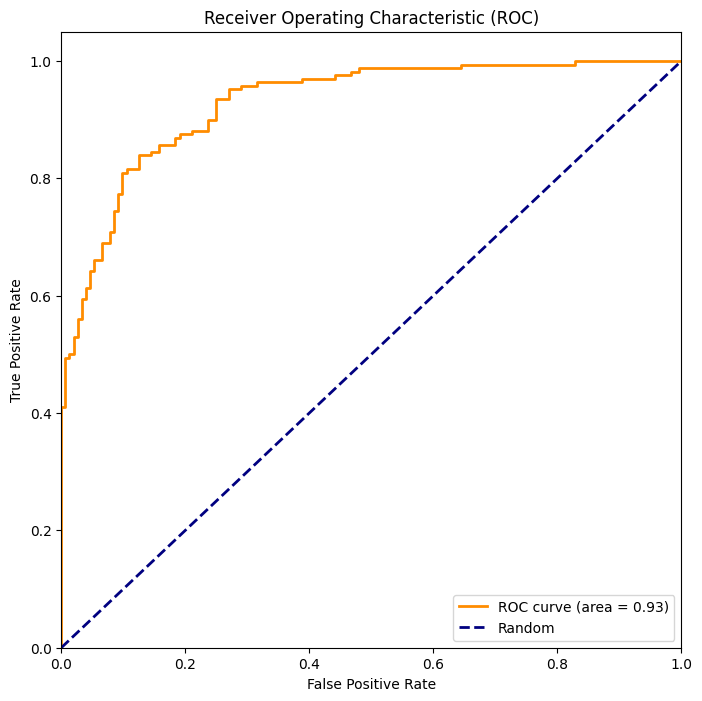

In [ ]:
# Plot predicted probabilities along with true labels
fpr, tpr, thresholds = roc_curve(y_test_encoded, linear_regression_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'copy_X':[True, False],'fit_intercept': [True, False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train_encoded)
best_model = grid_search.best_estimator_



In [ ]:
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True}


In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.3 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV

param_bounds = {'copy_X':[True, False],'fit_intercept': [True, False]}
bayes_search = BayesSearchCV(LinearRegression(), param_bounds, n_iter=50, cv=5)
bayes_search.fit(X_train_tfidf, y_train_encoded)
best_model_1 = bayes_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

In [ ]:
best_hyperparameters_1 = bayes_search.best_params_
print("Best Hyperparameters:", best_hyperparameters_1)

Best Hyperparameters: OrderedDict([('copy_X', True), ('fit_intercept', True)])


In [ ]:
#grapgh

In [ ]:
#ridge regression

In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge
ridge_regression_model = Ridge(alpha=1.0)  # You can adjust the alpha (regularization strength) parameter
ridge_regression_model.fit(X_train_tfidf, y_train_encoded)
ridge_regression_predictions = ridge_regression_model.predict(X_test_tfidf)
ridge_regression_predictions = [1 if pred > 0.5 else 0 for pred in ridge_regression_predictions]
print("Ridge Regression Accuracy:", accuracy_score(y_test_encoded, ridge_regression_predictions))
ridge_acc=accuracy_score(y_test_encoded, ridge_regression_predictions)

Ridge Regression Accuracy: 0.88125


In [ ]:
from sklearn.metrics import mean_squared_error
mse_ridge_alpha_is_1 = mean_squared_error(y_test_encoded, ridge_regression_predictions)
print(f'Mean Squared Error (Ridge): {mse_ridge_alpha_is_1}')

Mean Squared Error (Ridge): 0.11875


In [ ]:
recall_ridge= recall_score(y_test_encoded, ridge_regression_predictions)
precision_ridge = precision_score(y_test_encoded, ridge_regression_predictions)
f1_ridge= f1_score(y_test_encoded, ridge_regression_predictions)
print("Recall:", recall_ridge)
print("Precision:", precision_ridge)
print("F1-Score:", f1_ridge)

Recall: 0.8511904761904762
Precision: 0.9166666666666666
F1-Score: 0.882716049382716


In [ ]:


# Convert y_test_encoded to 1D array
y_test_encoded_1 = np.squeeze(y_test_encoded)

In [ ]:
y_test_encoded_1.shape

(320,)

In [ ]:
y_test_encoded.shape

(320, 1)

In [ ]:
# Sort the true values and corresponding Ridge Regression predicted values for plotting
sorted_indices = np.argsort(y_test_encoded_1)

In [ ]:
# Flatten any unnecessary dimensions
sorted_true_values = np.ravel(y_test_encoded_1[sorted_indices])
sorted_ridge_predicted_values = np.take(ridge_regression_predictions, sorted_indices)

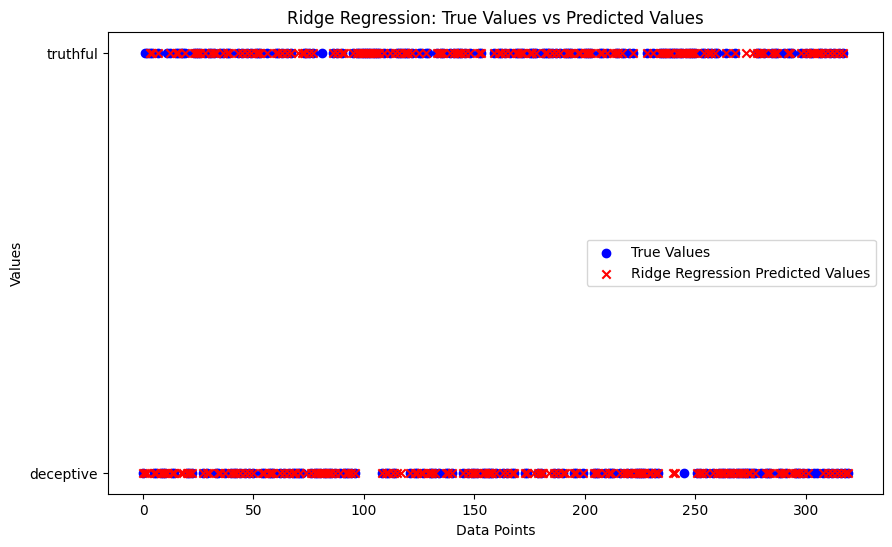

In [ ]:


# Scatter plot of individual data points
plt.figure(figsize=(10, 6))

plt.scatter(range(len(y_test)), y_test, label='True Values', marker='o', color='blue')
plt.scatter(range(len(y_test)), ridge_regression_predictions, label='Ridge Regression Predicted Values', marker='x', color='red')

plt.title('Ridge Regression: True Values vs Predicted Values')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()

In [ ]:
ridge_model_1 = Ridge()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}

grid_search = GridSearchCV(ridge_model_1, param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train_encoded)

best_params_r = grid_search.best_params_
print(f'Best Hyperparameters: {best_params_r}')

best_model_r = grid_search.best_estimator_

y_pred_ridge = best_model_r.predict(X_test_tfidf)


Best Hyperparameters: {'alpha': 0.1}


In [ ]:
ridge_model_1 = Ridge(alpha=0.1).fit(X_train_tfidf, y_train_encoded)
ridge_regression_pred = ridge_model_1.predict(X_test_tfidf)
ridge_regression_pred = [1 if pred > 0.5 else 0 for pred in ridge_regression_pred]
print("Ridge Regression Accuracy:", accuracy_score(y_test_encoded, ridge_regression_pred))
ridge_acc_r=accuracy_score(y_test_encoded, ridge_regression_pred)

Ridge Regression Accuracy: 0.86875


In [ ]:
from sklearn.metrics import mean_squared_error
mse_ridge = mean_squared_error(y_test_encoded, ridge_regression_pred)
print(f'Mean Squared Error (Ridge): {mse_ridge}')


Mean Squared Error (Ridge): 0.13125


In [ ]:
y_test_encoded_1.shape

(320,)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:
lasso_model = Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(lasso_model, param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train_encoded)

best_params = grid_search.best_params_

print(f'Best Hyperparameters: {best_params}')

best_model_lasso = grid_search.best_estimator_
y_pred_lasso = best_model_lasso.predict(X_test_tfidf)



Best Hyperparameters: {'alpha': 0.001}


In [ ]:
y_pred_lasso.shape

(320,)

In [ ]:
mse = mean_squared_error(y_test_encoded_1, y_pred_lasso)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.21875


In [ ]:
y_pred_lasso = [1 if pred > 0.5 else 0 for pred in y_pred_lasso]

In [ ]:
print("Lasso Regression Accuracy:", accuracy_score(y_test_encoded, y_pred_lasso))

Lasso Regression Accuracy: 0.78125


In [ ]:
recall_lasso= recall_score(y_test_encoded, y_pred_lasso)
precision_lasso = precision_score(y_test_encoded, y_pred_lasso)
f1_lasso= f1_score(y_test_encoded, y_pred_lasso)
print("Recall:", recall_lasso)
print("Precision:", precision_lasso)
print("F1-Score:", f1_lasso)

Recall: 0.7916666666666666
Precision: 0.7916666666666666
F1-Score: 0.7916666666666666


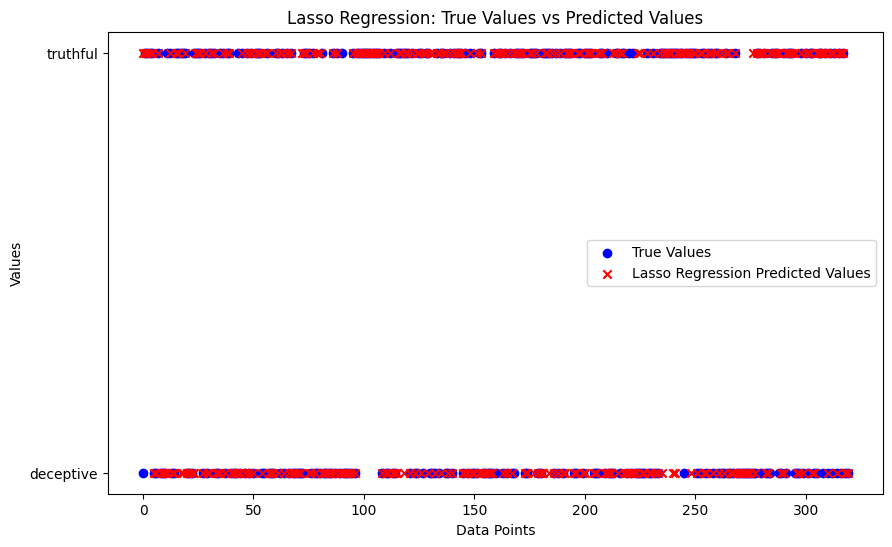

In [ ]:
# Scatter plot of individual data points
plt.figure(figsize=(10, 6))

plt.scatter(range(len(y_test)), y_test, label='True Values', marker='o', color='blue')
plt.scatter(range(len(y_test)), y_pred_lasso, label='Lasso Regression Predicted Values', marker='x', color='red')

plt.title('Lasso Regression: True Values vs Predicted Values')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()

clustering

Kmeans with knn- with different hyperparameters

In [51]:
#kmeans with knn
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
# K-Means clustering
kmeans_model = KMeans(n_clusters=2, random_state=42)
X_train_clusters = kmeans_model.fit_predict(X_train_tfidf)
X_test_clusters = kmeans_model.predict(X_test_tfidf)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [52]:
# Reshape cluster assignments to a 2D array
X_train_clusters_2d = X_train_clusters.reshape(-1, 1)
X_test_clusters_2d = X_test_clusters.reshape(-1, 1)

In [ ]:
X_train_clusters_2d[:5]

array([[0],
       [1],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
X_test_clusters_2d[:5]

array([[0],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [53]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Cluster Assignment')

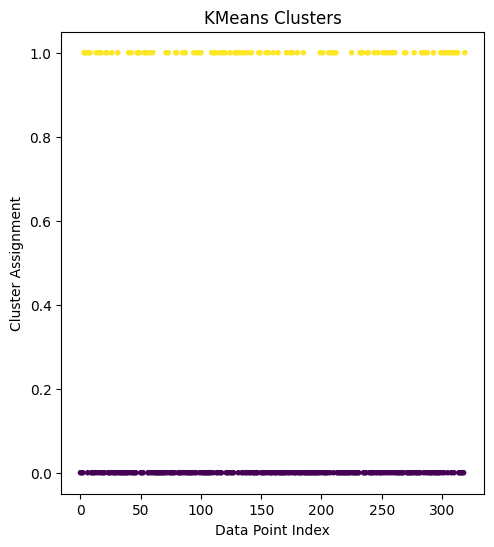

In [54]:
# Scatter plot for KMeans clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Convert sparse matrix to dense array
#X_test_tfidf_dense = X_test_tfidf.toarray()

# Convert Pandas Series to NumPy array
X_test_tfidf_dense = X_test.values.reshape(-1, 1)

# Plotting
plt.scatter(range(len(X_test_tfidf_dense)), X_test_clusters, c=X_test_clusters, cmap='viridis', marker='.')
plt.title('KMeans Clusters')
plt.xlabel('Data Point Index')
plt.ylabel('Cluster Assignment')
plt.title('KMeans Clusters')
plt.xlabel('Data Point Index')
plt.ylabel('Cluster Assignment')

In [55]:


# Concatenate the original TF-IDF features with one-hot encoded cluster assignments
X_train_combined = np.concatenate([X_train_tfidf.toarray(), X_train_clusters_2d], axis=1)
X_test_combined = np.concatenate([X_test_tfidf.toarray(), X_test_clusters_2d], axis=1)



In [56]:
# KNN classifier on cluster assignments
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_combined, y_train_encoded)

# Predict using the KNN classifier
knn_predictions = knn_classifier.predict(X_test_combined)

# Accuracy assessment
print("KNN Accuracy:", accuracy_score(y_test_encoded_1, knn_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, knn_predictions))

KNN Accuracy: 0.678125
Confusion Matrix:
[[136  16]
 [ 87  81]]


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [57]:
from sklearn.model_selection import GridSearchCV

In [60]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}

knn_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)
grid_search.fit(X_train_combined, y_train_encoded)

print("Best Hyperparameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test_combined)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Best Hyperparameters: {'n_neighbors': 9}


In [61]:
# Accuracy assessment
print("KNN Accuracy:", accuracy_score(y_test_encoded_1, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

KNN Accuracy: 0.684375
Confusion Matrix:
[[140  12]
 [ 89  79]]


In [62]:
recall_knn= recall_score(y_test_encoded, y_pred)
precision_knn = precision_score(y_test_encoded, y_pred)
f1_knn= f1_score(y_test_encoded, y_pred)
print("Recall:", recall_knn)
print("Precision:", precision_knn)
print("F1-Score:", f1_knn)

Recall: 0.47023809523809523
Precision: 0.8681318681318682
F1-Score: 0.61003861003861


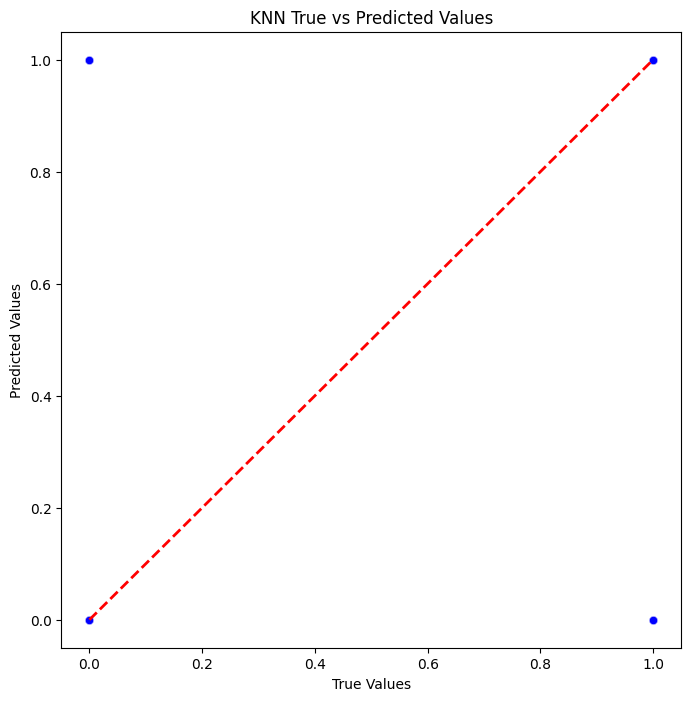

In [64]:
# Scatter plot for true vs predicted values
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_encoded_1, y=y_pred, marker='o', color='blue', alpha=0.5)
plt.plot([min(y_test_encoded_1), max(y_test_encoded_1)], [min(y_test_encoded_1), max(y_test_encoded_1)], linestyle='--', color='red', linewidth=2)
plt.title('KNN True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
# K-Means clustering with SVM


kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(X_train_tfidf)

# Assign clusters to the training and testing data
X_train_clusters = kmeans_model.predict(X_train_tfidf)
X_test_clusters = kmeans_model.predict(X_test_tfidf)

# Reshape cluster assignments to a 2D array
X_train_clusters_2D = X_train_clusters.reshape(-1, 1)
X_test_clusters_2D = X_test_clusters.reshape(-1, 1)


# Concatenate the original TF-IDF features with one-hot encoded cluster assignments
X_train_combined = np.concatenate([X_train_tfidf.toarray(), X_train_clusters_2D], axis=1)
X_test_combined = np.concatenate([X_test_tfidf.toarray(), X_test_clusters_2D], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [69]:
from sklearn.svm import SVC
# SVM classifier on cluster assignments
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_combined, y_train_encoded)

# Predict using the SVM classifier
svm_predictions = svm_classifier.predict(X_test_combined)

# Accuracy assessment
print("SVM Accuracy:", accuracy_score(y_test_encoded, svm_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, svm_predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.88125
Confusion Matrix:
[[138  14]
 [ 24 144]]


In [70]:
recall_SVM= recall_score(y_test_encoded, svm_predictions)
precision_SVM = precision_score(y_test_encoded, svm_predictions)
f1_SVM= f1_score(y_test_encoded, svm_predictions)
print("Recall:", recall_SVM)
print("Precision:", precision_SVM)
print("F1-Score:", f1_SVM)

Recall: 0.8571428571428571
Precision: 0.9113924050632911
F1-Score: 0.8834355828220858


In [66]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_svm = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Create the SVM classifier
svm_classifier = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid_svm, cv=5, scoring='accuracy')

# Train the model using grid search
grid_search.fit(X_train_combined, y_train_encoded)

# Get the best parameters
best_params_svm = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params_svm)




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}


In [67]:
# Predict using the best model
best_svm_model = grid_search.best_estimator_
svm_predictions = best_svm_model.predict(X_test_combined)

# Accuracy assessment
accuracy_svm = accuracy_score(y_test_encoded, svm_predictions)
conf_matrix_svm = confusion_matrix(y_test_encoded, svm_predictions)

print("SVM Accuracy:", accuracy_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)
recall_svm= recall_score(y_test_encoded, svm_predictions)
precision_svm = precision_score(y_test_encoded, svm_predictions)
f1_svm= f1_score(y_test_encoded, svm_predictions)
print("Recall:", recall_svm)
print("Precision:", precision_svm)
print("F1-Score:", f1_svm)

SVM Accuracy: 0.859375
Confusion Matrix:
[[135  17]
 [ 28 140]]
Recall: 0.8333333333333334
Precision: 0.89171974522293
F1-Score: 0.8615384615384616


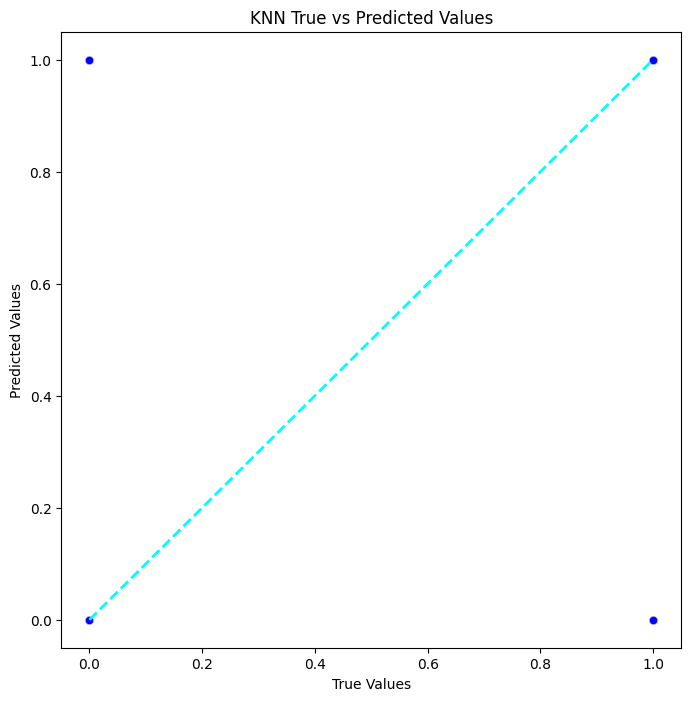

In [68]:
# Scatter plot for true vs predicted values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_encoded_1, y=svm_predictions, marker='o', color='blue', alpha=0.5)
plt.plot([min(y_test_encoded_1), max(y_test_encoded_1)], [min(y_test_encoded_1), max(y_test_encoded_1)], linestyle='--', color='cyan', linewidth=2)
plt.title('KNN True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

FUzzy c means with knn

In [ ]:
x[:5]

0    we stayed for a one night getaway with family ...
1    triple a rate with upgrade to view room was le...
2    this comes a little late as i m finally catchi...
3    the omni chicago really delivers on all fronts...
4    i asked for a high floor away from the elevato...
Name: complete_text, dtype: object

In [ ]:
pip install fuzzy-c-means


  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
bigframes 0.15.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [ ]:
#fuzzy-c means with knn

In [ ]:
from fcmeans import FCM

In [ ]:
import numpy as np

X_fcm = df['complete_text']
# Transform the text data into one-hot encoded features
X_tfidf = count_vectorizer.fit_transform(X_fcm)

In [ ]:
X_tfidf.shape

(1600, 9276)

In [ ]:


from sklearn.decomposition import TruncatedSVD
# Apply TruncatedSVD for dimensionality reduction
n_components = 2  # Choose an appropriate number of components
svd = TruncatedSVD(n_components=n_components)
X_tfidf_svd = svd.fit_transform(X_tfidf)

# Fuzzy C-Means clustering
n_clusters = 3  # Choose the number of clusters
fcm = FCM(n_clusters=n_clusters)
fcm.fit(X_tfidf_svd)

In [ ]:

y_pred_fcm = fcm.predict(X_tfidf_svd)

In [ ]:
X_tfidf_svd.shape

(1600, 2)

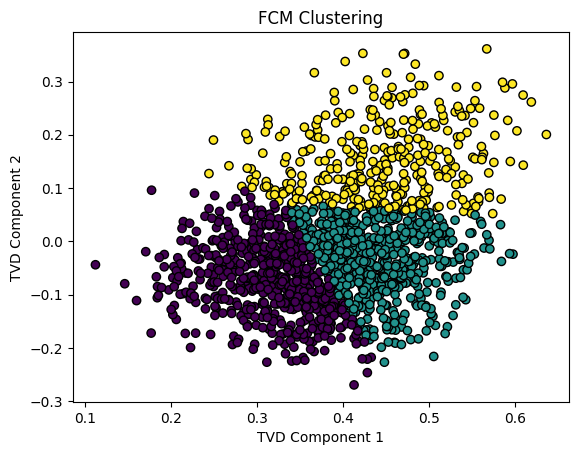

In [ ]:
plt.scatter(X_tfidf_svd[:, 0], X_tfidf_svd[:, 1], c=y_pred_fcm.ravel(), cmap='viridis', edgecolor='k')
plt.title('FCM Clustering')
plt.xlabel('TVD Component 1')
plt.ylabel('TVD Component 2')
plt.show()

In [ ]:
X_train_fcm, X_test_fcm, y_train, y_test = train_test_split(X_tfidf_svd, y, test_size=0.2, random_state=42)

In [ ]:
# Use OneHotEncoder for the 'label' column
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:

param_grid_knn_1 = {'n_neighbors': [3, 5, 7, 9]}
knn = KNeighborsClassifier()
grid_search_knn_1 = GridSearchCV(knn, param_grid_knn_1, cv=5)
grid_search_knn_1.fit(X_train_fcm, y_train_encoded)



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Best Hyperparameters: {'n_neighbors': 9}


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

In [ ]:
print("Best Hyperparameters:", grid_search_knn_1.best_params_)

Best Hyperparameters: {'n_neighbors': 9}


In [ ]:
y_pred_knn_1 = grid_search_knn_1.predict(X_test_fcm)

Accuracy: 85.62%


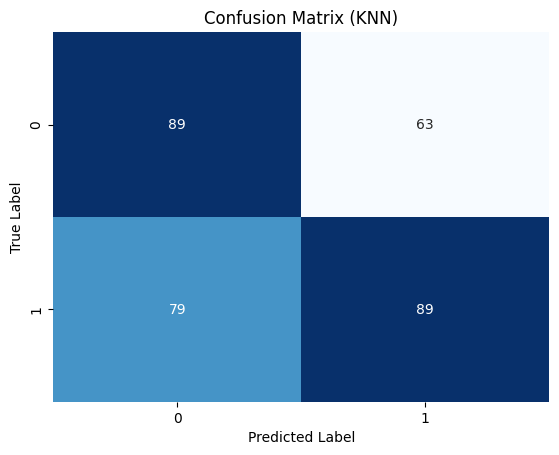

In [ ]:

accuracy_knn_1 = accuracy_score(y_test_encoded, y_pred_knn_1)
print(f'Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(y_test_encoded, y_pred_knn_1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (KNN)')
plt.show()


In [ ]:
y_test_encoded[:5]

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Classification Report
class_report = classification_report(y_test_encoded, y_pred_knn_1, target_names=["0","1"])


In [ ]:
print(class_report)

              precision    recall  f1-score   support

           0       0.53      0.59      0.56       152
           1       0.59      0.53      0.56       168

    accuracy                           0.56       320
   macro avg       0.56      0.56      0.56       320
weighted avg       0.56      0.56      0.56       320



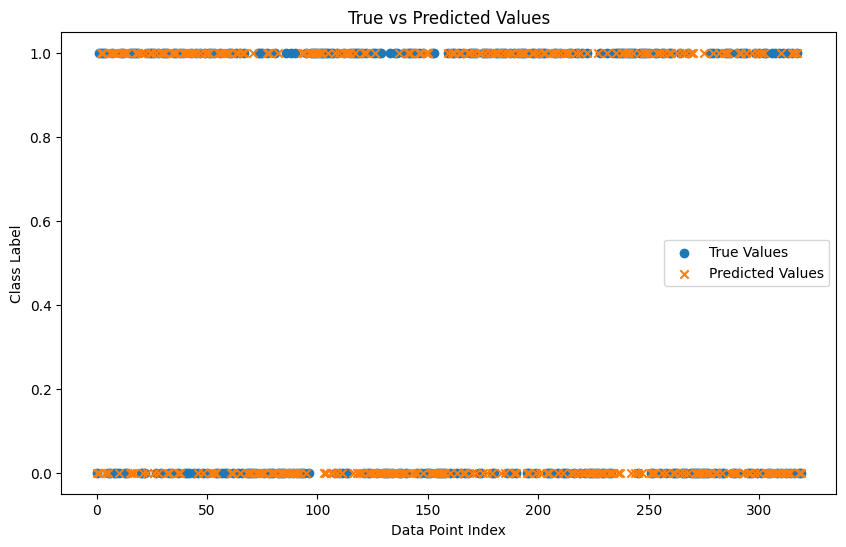

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_encoded)), y_test_encoded, label='True Values', marker='o')
plt.scatter(range(len(y_pred_knn_1)), y_pred_knn_1, label='Predicted Values', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Data Point Index')
plt.ylabel('Class Label')
plt.legend()
plt.show()

Bayesian Classifier

In [71]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming X_train_tfidf, y_train_encoded, X_test_tfidf, and y_test_encoded are your data
# X_train_tfidf and X_test_tfidf are assumed to be TF-IDF matrices

# Create and train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train_encoded)

# Predict using the trained classifier
nb_predictions = nb_classifier.predict(X_test_tfidf)

# Accuracy assessment
accuracy_nb = accuracy_score(y_test_encoded, nb_predictions)
conf_matrix_nb = confusion_matrix(y_test_encoded, nb_predictions)

print("Multinomial Naive Bayes Accuracy:", accuracy_nb)
print("Confusion Matrix:")
print(conf_matrix_nb)


Multinomial Naive Bayes Accuracy: 0.834375
Confusion Matrix:
[[146   6]
 [ 47 121]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
# Classification Report
from sklearn.metrics import classification_report
class_report_bayes = classification_report(y_test_encoded, nb_predictions, target_names=["0","1"])

In [74]:
print(class_report_bayes)

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       152
           1       0.95      0.72      0.82       168

    accuracy                           0.83       320
   macro avg       0.85      0.84      0.83       320
weighted avg       0.86      0.83      0.83       320



Multinomial Naive bayes using hyperparamters

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming X_train_tfidf, y_train_encoded, X_test_tfidf, and y_test_encoded are your data
# X_train_tfidf and X_test_tfidf are assumed to be TF-IDF matrices

# Create Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Define hyperparameters to tune
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # Adjust as needed
}

# Perform GridSearchCV
grid_search_nb = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train_tfidf, y_train_encoded)

# Get the best hyperparameters
best_alpha = grid_search_nb.best_params_['alpha']
print("Best Hyperparameters:", grid_search_nb.best_params_)
# Train the classifier with the best hyperparameters
best_nb_classifier = MultinomialNB(alpha=best_alpha)
best_nb_classifier.fit(X_train_tfidf, y_train_encoded)

# Predict using the best classifier
nb_predictions_1 = best_nb_classifier.predict(X_test_tfidf)

# Accuracy assessment
accuracy_nb1 = accuracy_score(y_test_encoded, nb_predictions_1)
conf_matrix_nb1 = confusion_matrix(y_test_encoded, nb_predictions_1)

print("Multinomial Naive Bayes Accuracy:", accuracy_nb1)
print("Confusion Matrix:")
print(conf_matrix_nb1)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Hyperparameters: {'alpha': 0.1}
Multinomial Naive Bayes Accuracy: 0.85625
Confusion Matrix:
[[138  14]
 [ 32 136]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [76]:
# Classification Report
from sklearn.metrics import classification_report
class_bayes = classification_report(y_test_encoded, nb_predictions_1, target_names=["0","1"])
print(class_bayes)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       152
           1       0.91      0.81      0.86       168

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



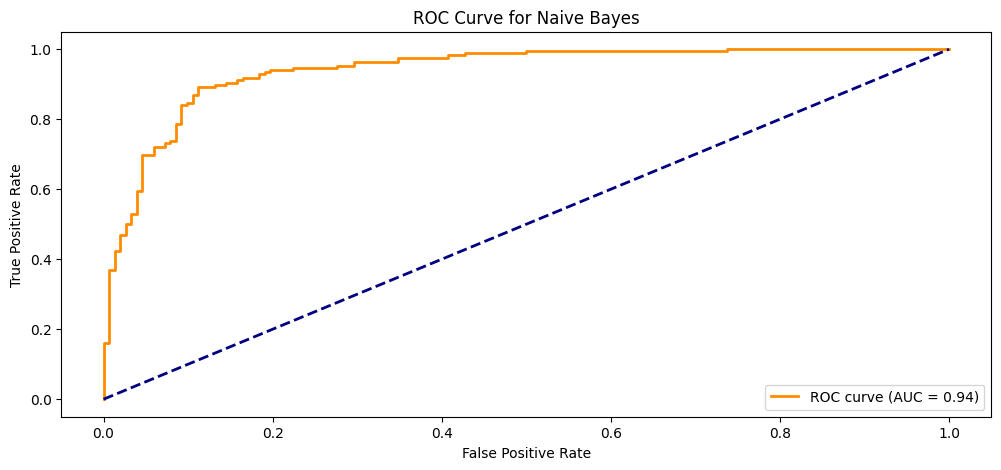

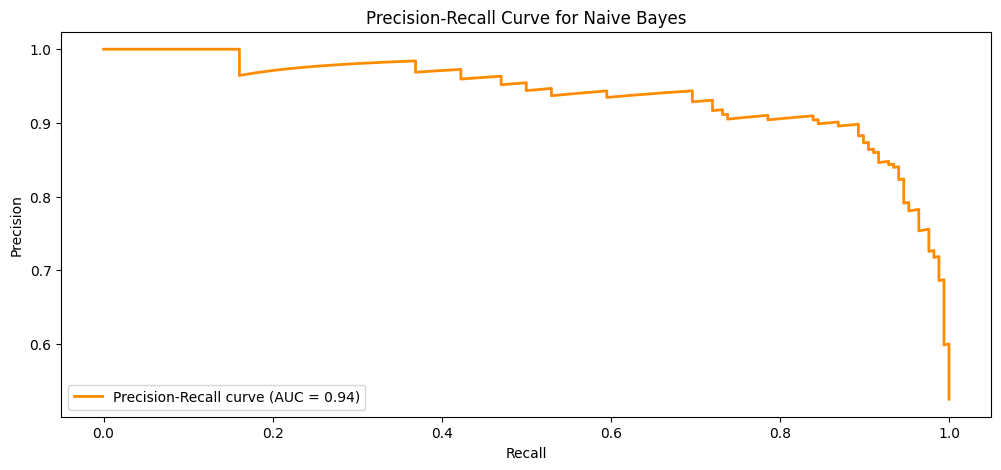

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming best_nb_classifier is your trained Naive Bayes classifier
# X_test_tfidf and y_test_encoded are your test data and labels

# Get predicted probabilities for positive class
y_scores_nb = best_nb_classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr_nb, tpr_nb, _ = roc_curve(y_test_encoded, y_scores_nb)

# Compute Precision-Recall curve
precision_nb, recall_nb, _ = precision_recall_curve(y_test_encoded, y_scores_nb)

# Compute area under the curves
roc_auc_nb = auc(fpr_nb, tpr_nb)
pr_auc_nb = auc(recall_nb, precision_nb)

# Plot ROC curve
plt.figure(figsize=(12, 5))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(12, 5))
plt.plot(recall_nb, precision_nb, color='darkorange', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc_nb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Naive Bayes')
plt.legend(loc='lower left')
plt.show()


In [77]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming X_train_tfidf, y_train_encoded, X_test_tfidf, and y_test_encoded are your data
# X_train_tfidf and X_test_tfidf are assumed to be TF-IDF matrices
# Convert sparse matrix to dense array
X_train_dense_1 = X_train_tfidf.toarray()
X_test_dense_1 = X_test_tfidf.toarray()
# Create and train the Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_dense_1, y_train_encoded)

# Predict using the trained classifier
gnb_predictions = gnb_classifier.predict(X_test_dense_1)

# Accuracy assessment
accuracy_gnb = accuracy_score(y_test_encoded, gnb_predictions)
conf_matrix_gnb = confusion_matrix(y_test_encoded, gnb_predictions)

print("Gaussian Naive Bayes Accuracy:", accuracy_gnb)
print("Confusion Matrix:")
print(conf_matrix_gnb)


Gaussian Naive Bayes Accuracy: 0.646875
Confusion Matrix:
[[ 95  57]
 [ 56 112]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
# Classification Report
from sklearn.metrics import classification_report
class_g_bayes = classification_report(y_test_encoded, gnb_predictions, target_names=["0","1"])
print(class_g_bayes)

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       152
           1       0.66      0.67      0.66       168

    accuracy                           0.65       320
   macro avg       0.65      0.65      0.65       320
weighted avg       0.65      0.65      0.65       320



decision tree

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming X_train_tfidf, y_train_encoded, X_test_tfidf, and y_test_encoded are your data
# X_train_tfidf and X_test_tfidf are assumed to be TF-IDF matrices

# Create and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_tfidf, y_train_encoded)

# Predict using the trained classifier
dt_predictions = dt_classifier.predict(X_test_tfidf)

# Accuracy assessment
accuracy_dt = accuracy_score(y_test_encoded, dt_predictions)
conf_matrix_dt = confusion_matrix(y_test_encoded, dt_predictions)

print("Decision Tree Accuracy:", accuracy_dt)
print("Confusion Matrix:")
print(conf_matrix_dt)




Decision Tree Accuracy: 0.715625
Confusion Matrix:
[[112  40]
 [ 51 117]]


In [80]:
# Classification Report
from sklearn.metrics import classification_report
class_dt = classification_report(y_test_encoded, dt_predictions, target_names=["0","1"])
print(class_dt)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       152
           1       0.75      0.70      0.72       168

    accuracy                           0.72       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.72      0.72      0.72       320



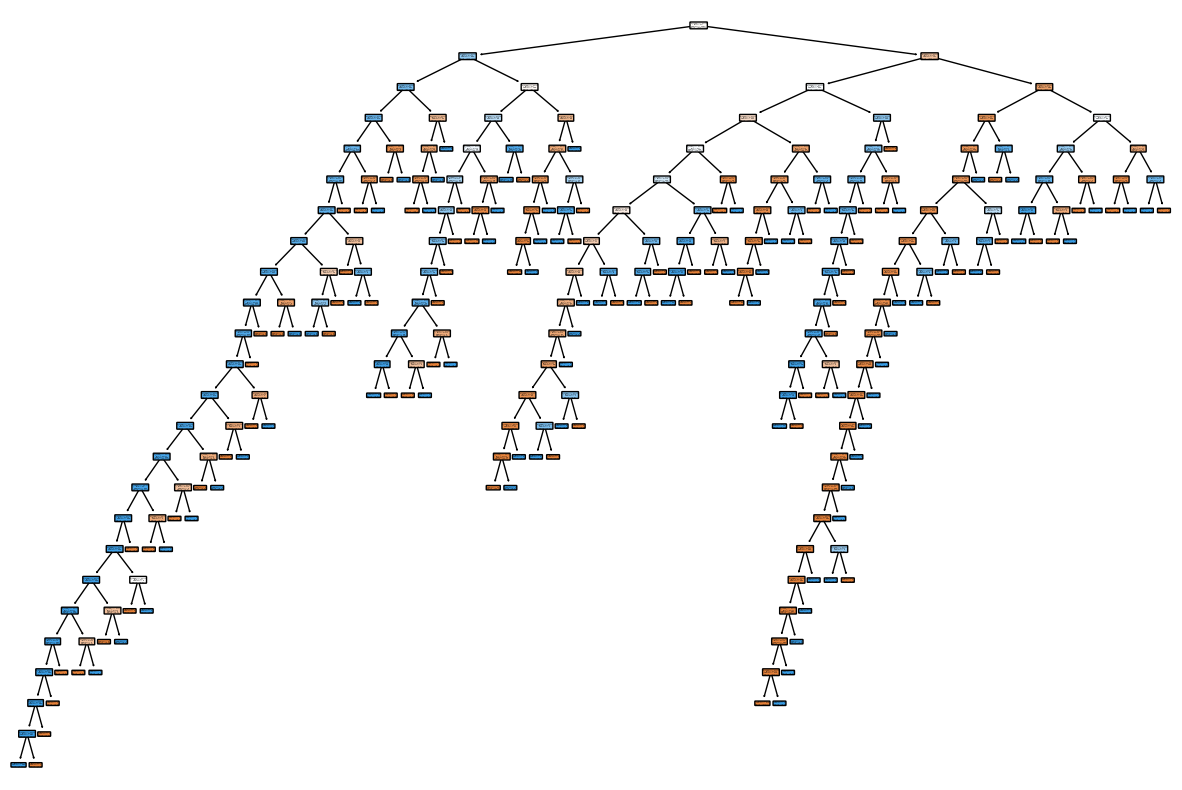

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
#import matplotlib.pyplot as plt

# Create and train the Decision Tree classifier
#dt_classifier = DecisionTreeClassifier(random_state=42)
#dt_classifier.fit(X_train_tfidf, y_train_encoded)

# Plot the Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, filled=True, feature_names=None, class_names=None, rounded=True)
plt.show()


In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming X_train_tfidf, y_train_encoded, X_test_tfidf, and y_test_encoded are your data
# X_train_tfidf and X_test_tfidf are assumed to be TF-IDF matrices

# Define the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to tune
param_grid_d= {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search_d = GridSearchCV(dt_classifier, param_grid_d, cv=5, scoring='accuracy')
grid_search_d.fit(X_train_tfidf, y_train_encoded)

# Get the best hyperparameters
best_params_d = grid_search_d.best_params_


# Train the classifier with the best hyperparameters
best_dt_classifier = DecisionTreeClassifier(random_state=42, **best_params_d)
best_dt_classifier.fit(X_train_tfidf, y_train_encoded)

# Predict using the best classifier
dt_predictions_1 = best_dt_classifier.predict(X_test_tfidf)

# Accuracy assessment
accuracy_d = accuracy_score(y_test_encoded, dt_predictions)
conf_matrix_d = confusion_matrix(y_test_encoded, dt_predictions)

print("Best Hyperparameters:", best_params_d)
print("Decision Tree Accuracy:", accuracy_d)
print("Confusion Matrix:")
print(conf_matrix_d)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.715625
Confusion Matrix:
[[112  40]
 [ 51 117]]


In [83]:
# Classification Report
from sklearn.metrics import classification_report
class_dt = classification_report(y_test_encoded, dt_predictions_1, target_names=["0","1"])
print(class_dt)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       152
           1       0.75      0.70      0.72       168

    accuracy                           0.72       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.72      0.72      0.72       320



<Figure size 1200x500 with 0 Axes>

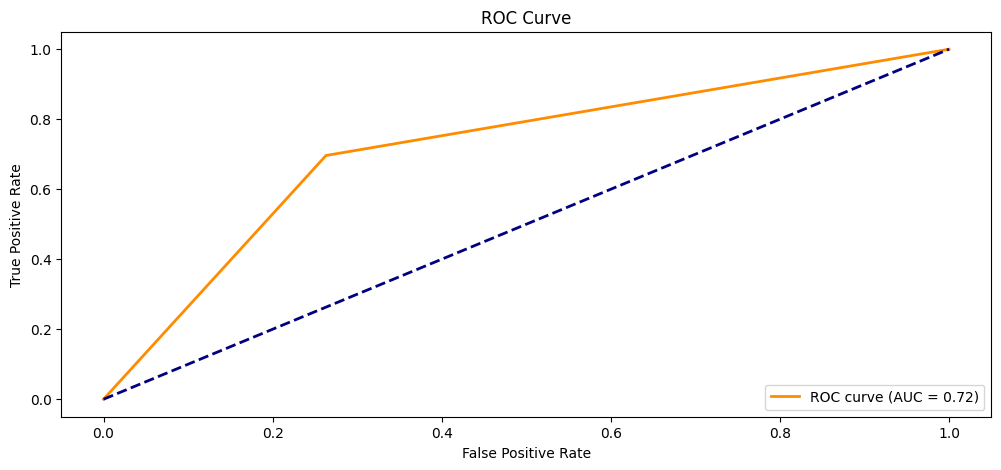

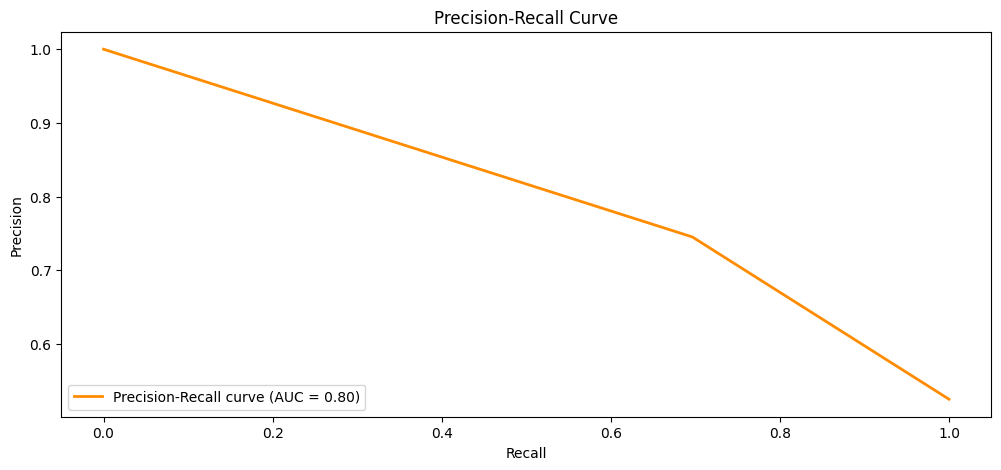

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming best_dt_classifier is your trained Decision Tree classifier
# X_test_tfidf and y_test_encoded are your test data and labels

# Plot ROC curve
plt.figure(figsize=(12, 5))
fpr, tpr, _ = roc_curve(y_test_encoded, dt_predictions)
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_encoded, dt_predictions)

# Compute area under the curves
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(12, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(12, 5))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

neural network- KMeans with CNN

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Assuming you have a DataFrame df with 'text' column containing the reviews and 'label' column indicating fake (0) or genuine (1)

# Use TF-IDF to convert text data to numerical features
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_tfidf = vectorizer.fit_transform(df['complete_text'])

# Apply K-Means clustering
n_clusters = 3  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Concatenate clusters with TF-IDF features
X_combined = np.concatenate([X_tfidf.toarray(), clusters.reshape(-1, 1)], axis=1)

# Split the data into training and testing sets
X_traincnn, X_testcnn, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
# Use OneHotEncoder for the 'label' column
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Define and train a simple CNN model
model = Sequential()
model.add(Embedding(input_dim=X_combined.shape[1], output_dim=128, input_length=X_combined.shape[1]))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_traincnn, y_train_encoded, epochs=5, batch_size=32, validation_data=(X_testcnn, y_test_encoded))




Epoch 1/5
40/40 [==============================] - 4s 83ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6960 - val_accuracy: 0.4750
Epoch 2/5
40/40 [==============================] - 4s 89ms/step - loss: 0.6936 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5250
Epoch 3/5
40/40 [==============================] - 6s 148ms/step - loss: 0.6938 - accuracy: 0.5031 - val_loss: 0.6935 - val_accuracy: 0.4750
Epoch 4/5
40/40 [==============================] - 4s 90ms/step - loss: 0.6937 - accuracy: 0.4938 - val_loss: 0.6939 - val_accuracy: 0.4750
Epoch 5/5
40/40 [==============================] - 3s 79ms/step - loss: 0.6934 - accuracy: 0.5063 - val_loss: 0.6938 - val_accuracy: 0.4750


In [ ]:
# Evaluate the model
accuracy = model.evaluate(X_test, y_test_encoded)[1]
print(f'Model Accuracy: {accuracy}')

10/10 [==============================] - 1s 81ms/step - loss: 0.6938 - accuracy: 0.4750
Model Accuracy: 0.4749999940395355


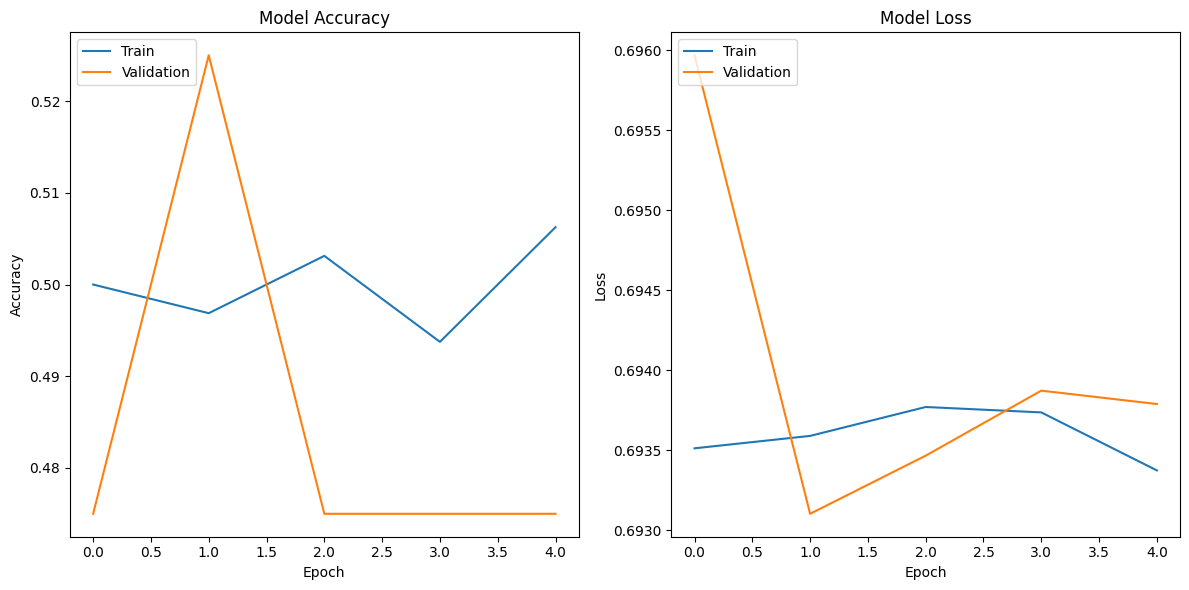

In [ ]:
#Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()